In [2]:
import sf_quant as sf
from sf_quant.data.factors import load_factors, get_factor_names
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

/home/ammonml/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 23:08:35,811	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
start = dt.date(2000,1,1)
end = dt.date(2020,1,1)

factors = get_factor_names(type = 'style')
daily = load_factors(start=start, end=end, factors=factors)
daily = daily.unpivot(index='date', variable_name='factor', value_name='ret')
daily = daily.to_pandas()
daily['ret'] = daily['ret'] / 100

daily

,date,factor,ret
0,2000-01-03,USSLOWL_BETA,0.002082
1,2000-01-04,USSLOWL_BETA,-0.006150
2,2000-01-05,USSLOWL_BETA,-0.002357
3,2000-01-06,USSLOWL_BETA,-0.003232
4,2000-01-07,USSLOWL_BETA,0.010328
...,...,...,...
80491,2019-12-24,USSLOWL_VALUE,-0.000262
80492,2019-12-26,USSLOWL_VALUE,0.000784
80493,2019-12-27,USSLOWL_VALUE,-0.000576
80494,2019-12-30,USSLOWL_VALUE,0.002228


In [ ]:
# ensure date is datetime and sorted
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').reset_index(drop=True)

#  sanity
print(daily.shape)
print(daily[['date','factor','ret']].head())


(80496, 3)
        date            factor       ret
0 2000-01-03      USSLOWL_BETA  0.002082
1 2000-01-03    USSLOWL_GROWTH  0.000750
2 2000-01-03  USSLOWL_PROSPECT  0.001361
3 2000-01-03    USSLOWL_MIDCAP -0.008467
4 2000-01-03  USSLOWL_MGMTQLTY  0.000153


In [ ]:
# make wide just cuz I like wide
df_wide = daily.pivot(index='date', columns='factor', values='ret')

# inspect
print(df_wide.iloc[:5, :6])   # first 5 days, first 6 factors


factor      USSLOWL_BETA  USSLOWL_DIVYILD  USSLOWL_EARNQLTY  USSLOWL_EARNYILD  \
date                                                                            
2000-01-03      0.002082         0.003872         -0.001783         -0.003072   
2000-01-04     -0.006150         0.002260         -0.001040         -0.003219   
2000-01-05     -0.002357         0.001087          0.001407         -0.000638   
2000-01-06     -0.003232         0.000837         -0.001297         -0.008606   
2000-01-07      0.010328         0.001931          0.002356          0.000796   

factor      USSLOWL_GROWTH  USSLOWL_LEVERAGE  
date                                          
2000-01-03        0.000750         -0.000388  
2000-01-04       -0.001458         -0.001253  
2000-01-05        0.002668         -0.002630  
2000-01-06       -0.005088          0.001236  
2000-01-07        0.001843         -0.000160  


In [ ]:
# monthly cumulative returns per factor (at month-end)
monthly = (1 + df_wide).resample('M').prod() - 1
monthly.index.name = 'month_end'

# optional: convert index to first-of-month for alignment if you prefer
# monthly.index = monthly.index.to_period('M').to_timestamp('M')

print("monthly shape:", monthly.shape)
print(monthly.iloc[:5, :6])


monthly shape: (240, 16)
factor      USSLOWL_BETA  USSLOWL_DIVYILD  USSLOWL_EARNQLTY  USSLOWL_EARNYILD  \
month_end                                                                       
2000-01-31      0.009330         0.000898         -0.004636         -0.024407   
2000-02-29      0.034641         0.008303         -0.001145         -0.008864   
2000-03-31     -0.028798        -0.015709         -0.003108         -0.001284   
2000-04-30     -0.024169        -0.000629          0.019096          0.030531   
2000-05-31     -0.014748         0.006795          0.008405          0.019679   

factor      USSLOWL_GROWTH  USSLOWL_LEVERAGE  
month_end                                     
2000-01-31        0.002257         -0.002422  
2000-02-29        0.005712         -0.014273  
2000-03-31       -0.008179          0.003979  
2000-04-30       -0.033073          0.013417  
2000-05-31       -0.009774          0.001598  


/tmp/ipykernel_1626274/2008168144.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = (1 + df_wide).resample('M').prod() - 1


In [7]:
# Use previous-month returns to form signal at time t
monthly_lag = monthly.shift(1)   # index t contains returns from t-1

# cross-sectional median (for each row/month)
cs_median = monthly_lag.median(axis=1)

# signal: +1 if > median, -1 if < median, 0 if equal (NaNs propagate)
signals = monthly_lag.gt(cs_median, axis=0).astype(int) - monthly_lag.lt(cs_median, axis=0).astype(int)

# Optional: fill NaN signals with 0 if you prefer neutral instead of NaN
# signals = signals.fillna(0)

# quick peek (month index = signal month)
print(signals.iloc[-6:, :6])   # last 6 months, first 6 factors


factor      USSLOWL_BETA  USSLOWL_DIVYILD  USSLOWL_EARNQLTY  USSLOWL_EARNYILD  \
month_end                                                                       
2019-07-31             1               -1                -1                 1   
2019-08-31            -1               -1                -1                -1   
2019-09-30            -1               -1                 1                -1   
2019-10-31             1                1                 1                 1   
2019-11-30             1               -1                -1                -1   
2019-12-31             1                1                -1                 1   

factor      USSLOWL_GROWTH  USSLOWL_LEVERAGE  
month_end                                     
2019-07-31              -1                 1  
2019-08-31               1                -1  
2019-09-30               1                 1  
2019-10-31              -1                 1  
2019-11-30              -1                 1  
2019-12-31            

In [10]:
# Element-wise multiply signals by factor returns
long_short_matrix = signals * monthly

# For each month: sum of (signal * return) / number of active signals
# (avoid dividing by zero if a month has no signals)
strategy_monthly = long_short_matrix.sum(axis=1) / signals.abs().sum(axis=1)

# Clean up NaNs
strategy_monthly = strategy_monthly.dropna()
strategy_cum = (1 + strategy_monthly).cumprod() - 1



In [11]:
print("Annualized mean return:", strategy_monthly.mean() * 12)
print("Annualized volatility:", strategy_monthly.std() * np.sqrt(12))
print("Sharpe ratio:", strategy_monthly.mean() / strategy_monthly.std() * np.sqrt(12))
print("Cumulative return:", strategy_cum.iloc[-1])


Annualized mean return: 0.004192202427885856
Annualized volatility: 0.010577809801475541
Sharpe ratio: 0.39632045825791534
Cumulative return: 0.08586018696749664


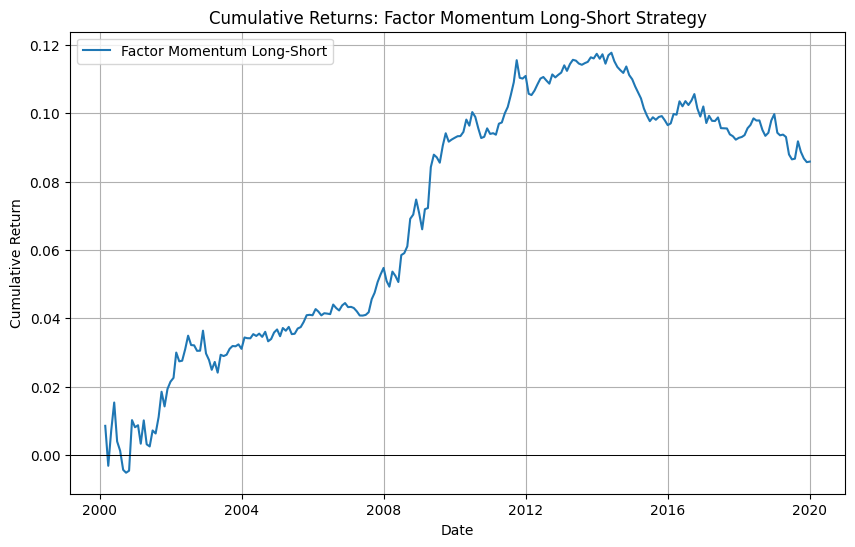

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(strategy_cum.index, strategy_cum.values, label='Factor Momentum Long-Short')
plt.axhline(0, color='black', linewidth=0.7)
plt.title("Cumulative Returns: Factor Momentum Long-Short Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


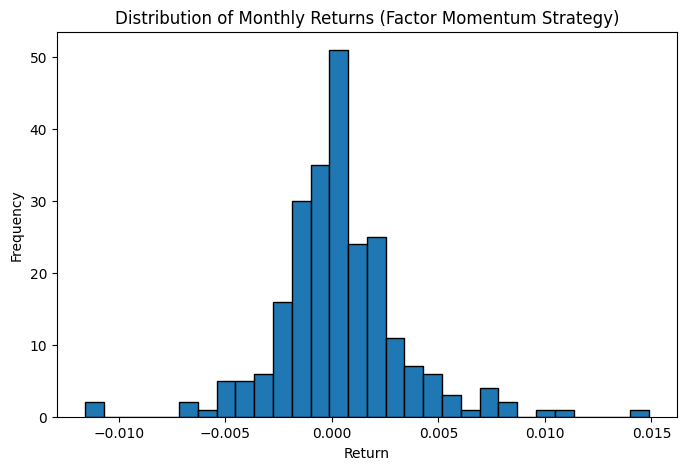

In [13]:
plt.figure(figsize=(8,5))
plt.hist(strategy_monthly, bins=30, edgecolor='k')
plt.title("Distribution of Monthly Returns (Factor Momentum Strategy)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()
